In [1]:
from qiskit.ml.datasets import *
from qiskit import QuantumCircuit
from qiskit.aqua.components.optimizers import COBYLA, ADAM, SPSA
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# constants
n = 4
RANDOM_STATE = 42
LR = 1e-3
class_labels = ['yes', 'no']

In [3]:
def normalizeData(DATA_PATH = "../../Data/Processed/data.csv"):
    """
    Normalizes the data
    """
    # Reads the data
    data = pd.read_csv(DATA_PATH)
    data = shuffle(data, random_state=RANDOM_STATE)
    X, Y = data[['sex', 'cp', 'exang', 'oldpeak']].values, data['num'].values
    # normalize the data
    X = normalize(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

In [4]:
X_train, X_test, Y_train, Y_test = normalizeData()

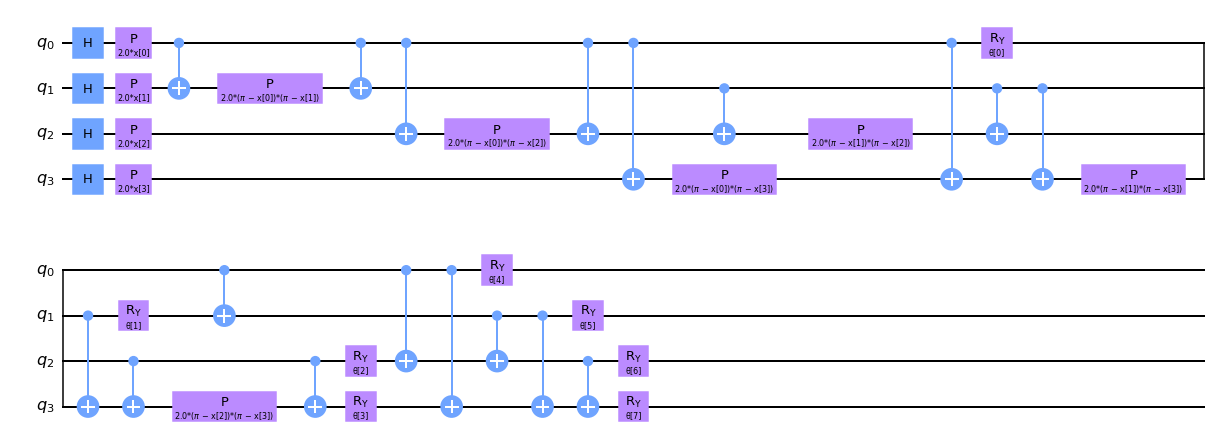

In [5]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.draw(output='mpl')

In [6]:
def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = params[i]
    return parameters

In [7]:
X_train[0]

array([0.4472136 , 0.89442719, 0.        , 0.        ])

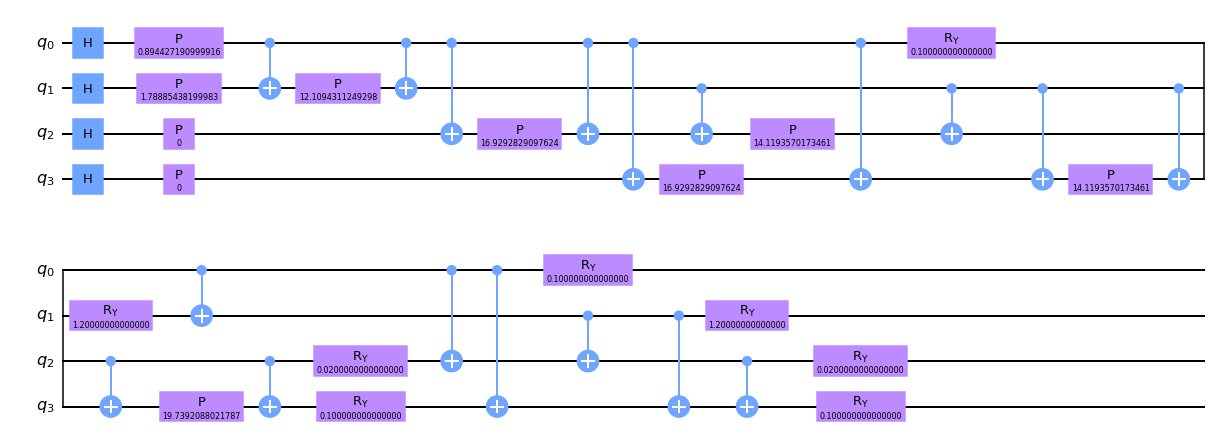

In [8]:
data = X_train[0]
params = np.array([0.1, 1.2, 0.02, 0.1, 0.1, 1.2, 0.02, 0.1])
circ_ = circuit.assign_parameters(get_data_dict(params, data))
circ_.draw(plot_barriers=True)

In [9]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

In [10]:
def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
    class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

In [11]:
return_probabilities({'00' : 10, '01': 10, '11': 20}, class_labels)


{'yes': 0.75, 'no': 0.25}

In [12]:
def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circ_)
        qc_list += [qc]
        probs = []
    for qc in qc_list:
        counts = qc.to_counts()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs

In [13]:
x = np.asarray([X_train[0]])
classify(x, params=np.array([0.8, -0.5, 1.5, 0,5, 0.8, -0.5, 1.5, 0,5]), class_labels=class_labels)

[{'yes': 0.6338620140853923, 'no': 0.3661379859146076}]

In [14]:
def cost_estimate_sigmoid(probs, expected_label): # probability of labels vs actual labels
    p = probs.get(expected_label)
    sig = None
    if np.isclose(p, 0.0):
        sig = 1
    elif np.isclose(p, 1.0):
        sig = 0
    else:
        denominator = np.sqrt(2*p*(1-p))
        x = np.sqrt(200)*(0.5-p)/denominator
        sig = 1/(1+np.exp(-x))
    return sig

In [15]:
def mse_cost(probs, expected_label):
    p = probs.get(expected_label)
    actual, pred = np.array(1), np.array(p)
    return np.square(np.subtract(actual,pred)).mean()

In [16]:
def rmse_cost(probs, expected_label): 
    p = probs.get(expected_label)    
    actual, pred = np.array(1), np.array(pred)
    return np.sqrt(np.square(np.subtract(actual,pred)).mean())

In [17]:
cost_list = []
def cost_function(X, Y, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    for label in Y:
        if label == 0:
            training_labels += [class_labels[0]]
        elif label == 1:
            training_labels += [class_labels[1]]
    probs = classify(training_samples, params, class_labels)
    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += mse_cost(prob, training_labels[i])
    cost /= len(training_samples)
    # print resulting objective function
    if print_value:
        print('%.4f' % cost)
    # return objective value
    cost_list.append(cost)
    return cost

In [18]:
cost_function(X_train, Y_train, class_labels, params)

0.22354962821107346

In [19]:
cost_list = []
optimizer = COBYLA(maxiter=100)
# optimizer = ADAM(maxiter=100, lr=LR)

# define objective function for training
objective_function = lambda params: cost_function(X_train, Y_train, class_labels, params, print_value=True)
# randomly initialize the parameters
np.random.seed(RANDOM_STATE)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

0.2878
0.3064
0.2700
0.2726
0.2374
0.2976
0.2064
0.2623
0.2178
0.2464
0.2139
0.2112
0.2172
0.2086
0.1970
0.2038
0.1936
0.1876
0.1869
0.1883
0.1873
0.1871
0.1831
0.1890
0.1838
0.1792
0.1792
0.1779
0.1773
0.1758
0.1737
0.1724
0.1732
0.1729
0.1711
0.1705
0.1711
0.1717
0.1705
0.1691
0.1684
0.1679
0.1683
0.1682
0.1679
0.1681
0.1672
0.1685
0.1672
0.1673
0.1670
0.1668
0.1668
0.1668
0.1667
0.1666
0.1666
0.1666
0.1665
0.1664
0.1663
0.1663
0.1666
0.1664
0.1664
0.1664
0.1664
0.1663
0.1663
0.1663
0.1663
0.1663
0.1662
0.1662
0.1662
0.1662
0.1662
0.1663
0.1662
0.1662
0.1663
0.1662
0.1662
0.1662
0.1662
0.1662
0.1662
0.1662
0.1662
0.1662
0.1662
0.1662
0.1662
0.1662
0.1662
0.1662
0.1662
0.1661
0.1661
0.1662

opt_params: [ 2.64437302  7.15932798  4.79014299  3.36126229  0.53175562  2.433114
 -0.21950408  5.2998132 ]
opt_value:  0.16614039808504724


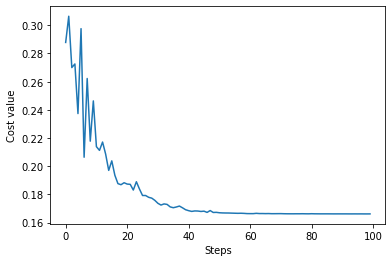

In [20]:
plt.plot(range(0,100,1), cost_list)
plt.xlabel('Steps')
plt.ylabel('Cost value')
plt.show()

In [21]:
def test_model(X, Y, class_labels, params):
    accuracy = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    probs = classify(training_samples, params, class_labels)
    for i, prob in enumerate(probs):
        if (prob.get('yes') >= prob.get('no')) and (Y_test[i] == 0):
            accuracy += 1
        elif (prob.get('no') >= prob.get('yes')) and (Y_test[i] == 1):
            accuracy += 1
    accuracy /= len(Y_test)
    print("Test accuracy: {}\n".format(accuracy))

In [22]:
test_model(X_test, Y_test, class_labels, opt_params)

Test accuracy: 0.7613636363636364

